<a href="https://colab.research.google.com/github/compressed-sensing/algorithms/blob/feature%2Fnotebooks/notebooks/TV_Debluring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 2D Total variation deblurring

Our signal model:
$$y = h \ast x + \omega \quad \text{where} \quad w\sim\mathcal{N}(0,\sigma^2I).$$

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import scipy.signal as signal
import scipy.fft as fft
import urllib.request

<class 'numpy.ndarray'>
(512, 512)


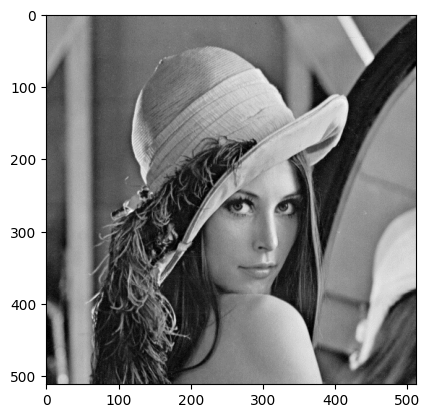

In [ ]:
# Reading image (grayscale)
url = 'https://i.stack.imgur.com/kP0u2.png'
  # url='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSRsK5QFJ1arEQlnHEJ-020xbO30BgdYgPJBg&usqp=CAU'
  #url='https://unsplash.com/photos/IoZA1Mwiq2g/download?ixid=MnwxMjA3fDB8MXxzZWFyY2h8MTZ8fGJsYWNrJTIwYW5kJTIwd2hpdGUlMjBmbG93ZXJ8ZW58MHx8fHwxNjc5MzQxODY4&force=true&w=640'
with urllib.request.urlopen(url) as url_response:
  img_array = np.asarray(bytearray(url_response.read()), dtype=np.uint8)
  img = cv2.imdecode(img_array, cv2.IMREAD_GRAYSCALE)
# img is a 3-dimensional numpy array (third number indicates channel)
x = img.astype(float)/255.
print(type(img)) 
print(img.shape) 
plt.imshow(x, cmap ='gray')

In [ ]:
### Define some of the operators that we need...
def conv2d_fft(x, h):
    p0 = x.shape[0]-h.shape[0]
    p1 = x.shape[1]-h.shape[1]
    h_pad = np.pad(h, ((0,p0),(0,p1)))
    Fh = fft.fft2(h_pad)
    Fx = fft.fft2(x)
    return np.real(fft.ifft2(Fx*Fh))

def conv2dT_fft(x, h):
    p0 = x.shape[0]-h.shape[0]
    p1 = x.shape[1]-h.shape[1]
    h_pad = np.pad(h, ((0,p0),(0,p1)))
    Fh = fft.fft2(h_pad)
    Fx = fft.fft2(x)
    return np.real(fft.ifft2(Fx*np.conj(Fh)))

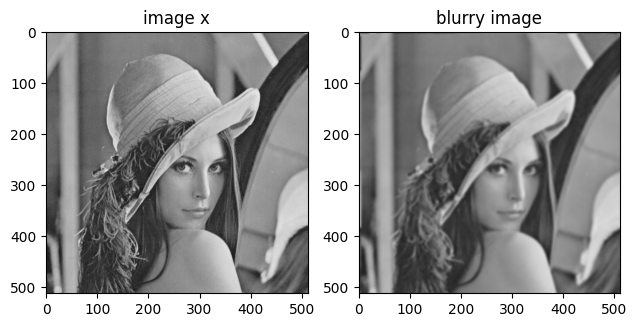

(512, 512)


In [ ]:
# the blurring kernel
h = np.ones([7,7])
h /= h.sum()
# Make image blurry
h = cv2.getGaussianKernel(9,2)
h = np.dot(h,h.T)

H  = lambda x: conv2d_fft(x,h)
HT = lambda x: conv2dT_fft(x,h)

# form the observed image
sigma = 5./255.
y = H(x) + (sigma**2) * np.random.randn(*x.shape)

fig = plt.figure()
plt.subplot(121)
plt.imshow(x, cmap='gray', clim=[0,1])
plt.title('image x')
plt.subplot(122)
plt.imshow(y, cmap='gray', clim=[0,1])
plt.title('blurry image')
#plt.imshow(y, cmap='gray', clim=[0,1])
#plt.title('y = h * x + w')
plt.tight_layout()
plt.show()
print(y.shape)

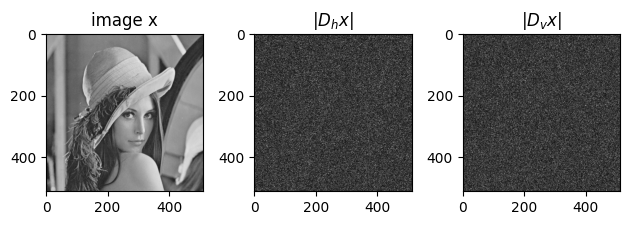

In [ ]:
# define gradient operators
dh = np.array([[1,-1],[0, 0]]) # horizontal gradient filter
dv = np.array([[1, 0],[-1,0]]) # vertical gradient filter

Dh = lambda x: conv2d_fft(x, dh)
Dv = lambda x: conv2d_fft(x, dv)

DhT = lambda x: conv2dT_fft(x, dh)
DvT = lambda x: conv2dT_fft(x, dv)

# plot the image x and the gradient images Dh x and Dv x
fig = plt.figure()
plt.subplot(131)
plt.imshow(x, cmap='gray', clim=[0,1]);
plt.title('image x')
plt.subplot(132)
plt.imshow(np.abs(Dh(y)), cmap='gray', clim=[0,1]);
plt.title(r'$|D_hx|$')
plt.subplot(133)
plt.imshow(np.abs(Dv(y)), cmap='gray', clim=[0,1]);
plt.title(r'$|D_vx|$')
plt.tight_layout()
plt.show()

## TV-debluring problem formulation

Problem formulation:

$$\underset{x}{\mathrm{minimize}}~~\underbrace{\frac{\mu}{2} \|y - Hx\|_2^2}_{\text{data fidelity}} +\underbrace{ \left\| D x \right\|_1}_{\text{regularization: sparse gradient}}$$

where $D = \begin{bmatrix}D_h\\D_v\end{bmatrix}$. A quick note on the TV-norm: there are two types of TV-norm usually used in the literature:

$$\begin{cases}\text{anisotropic:  } &\|Dx\|_1 = \sum_i \left|(D_h x)_i\right|+\left|(D_v x)_i\right| \\ \\ \text{isotropic:  } &\|Dx\|_{TV2} = \sum_i \sqrt{(D_h x)_i^2+(D_v x)_i^2}\end{cases}$$

we are using anisotropic TV-norm for our formulation. You can read more about the both cases in [this paper](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=5779734).

#### Let's derive ADMM iterations!

Problem in ADMM form:

$$\underset{x,z}{\mathrm{minimize}}~~\frac{\mu}{2} \|y - Hx\|_2^2 +\|z\|_1, \quad \text{subject to:}\quad Dx - z = 0$$

The augmented Lagrangian:

$$\mathcal{L}(x,z,u) = \frac{\mu}{2} \|y - Hx\|_2^2 +\|z\|_1 + \frac{\rho}{2} \|Dx - z + u\|_2^2$$

ADMM iterations:

- for $k = 1, \cdots, K$:
    -  update $x$:
    
    $$x^{k+1} \leftarrow \arg\min_{x}~\mathcal{L}(x,z^k,u^k) \equiv \arg\min_{x}~ \frac{\mu}{2} \|y - Hx\|_2^2 + \frac{\rho}{2} \|Dx - z^{k} + u^{k}\|_2^2 $$
    
    - update $z$:
    
    $$z^{k+1} \leftarrow \arg\min_{z}~\mathcal{L}(x^{k+1},z,u^k) \equiv \arg\min_{z}~ \frac{\mu}{2} \|z\|_1 + \frac{\rho}{2} \|z - (Dx^{k+1} + u^{k})\|_2^2 $$ 


    - update $u$:
    
    $$u^{k+1} \leftarrow u^{k} + \rho (Dx^{k+1} - z^{k+1}) $$

In [ ]:
# a TV-deblurring solver
def TV_debluring(y, h, mu=1e3, rho=1e1, maxiter=200):
    '''
        TV-deblurring solver to solve
        minimize 0.5 mu |y-Hx|_2^2 + |Dx|_1
    '''
    # define the soft-thresholding function
    soft_thresh = lambda v, t: np.maximum(np.abs(v)-t, 0.)*np.sign(v)
    # initilize our operators
    H  = lambda x: conv2d_fft(x,h)
    HT = lambda x: conv2dT_fft(x,h)
    # the HHT can be computed using fft2
    p0 = x.shape[0]-h.shape[0]
    p1 = x.shape[1]-h.shape[1]
    h_pad = np.pad(h, ((0,p0),(0,p1)))
    HHT = np.abs(fft.fft2(h_pad))**2 
    
    # define gradient operators
    dh = np.array([[1,-1],[0, 0]]) # horizontal gradient filter
    dv = np.array([[1, 0],[-1,0]]) # vertical gradient filter

    Dh = lambda x: conv2d_fft(x, dh)
    Dv = lambda x: conv2d_fft(x, dv)

    DhT = lambda x: conv2dT_fft(x, dh)
    DvT = lambda x: conv2dT_fft(x, dv)
    
    # DDT
    p0 = x.shape[0]-dh.shape[0]
    p1 = x.shape[1]-dh.shape[1]
    dh_pad = np.pad(dh, ((0,p0),(0,p1)))
    
    p0 = x.shape[0]-dv.shape[0]
    p1 = x.shape[1]-dv.shape[1]
    dv_pad = np.pad(dv, ((0,p0),(0,p1)))
    
    DDT = np.abs(fft.fft2(dh_pad))**2 +\
          np.abs(fft.fft2(dv_pad))**2

    # initilize iteration variables
    zh = np.zeros_like(y)
    zv = np.zeros_like(y)
    uh = np.zeros_like(zh)
    uv = np.zeros_like(zv)
    x_hat = np.zeros_like(y)
    J = np.zeros(maxiter)

    for k in range(maxiter):
        # solve the L2-L2 problem
        rhs = mu * HT(y) + rho * (DhT(zh) + DvT(zv)) - DhT(uh) - DvT(uv)
        F_rhs = fft.fft2(rhs)
        x_hat = np.real(fft.ifft2(F_rhs/(rho * DDT + mu * HHT)))

        # solve the TV problem
        zh = soft_thresh(Dh(x_hat)+ (1./rho)*uh, 1./rho)
        zv = soft_thresh(Dv(x_hat)+ (1./rho)*uv, 1./rho)

        # update u
        dual_h = rho*(zh - Dh(x_hat))
        dual_v = rho*(zv - Dv(x_hat))
        uh = uh - dual_h
        uv = uv - dual_v

        # compute the error
        J[k] = (dual_h**2).sum()+(dual_v**2).sum()
    return x_hat, J

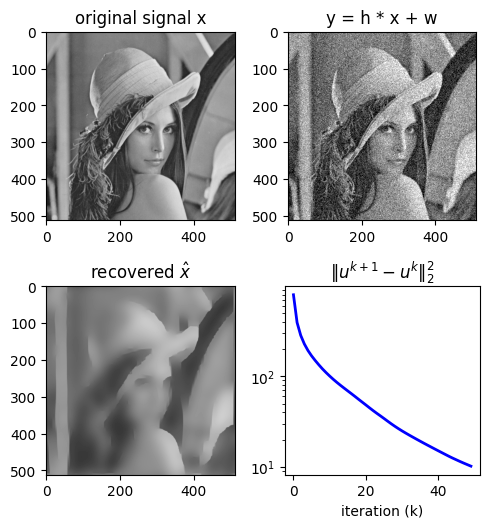

In [ ]:
x_hat, J = TV_debluring(y, h, mu=1, rho=2, maxiter=50)

fig = plt.figure()
fig.set_size_inches(5,7.5)
ax = fig.add_subplot(321)
ax.imshow(x, cmap='gray', clim=[0,1])
plt.title('original signal x')
ax2 = fig.add_subplot(322)
ax2.imshow(y, cmap='gray', clim=[0,1])
plt.title('y = h * x + w')
ax3 = fig.add_subplot(323)
ax3.imshow(x_hat, cmap='gray', clim=[0,1])
plt.title(r'recovered $\hat{x}$')
ax4 = fig.add_subplot(324)
ax4.semilogy(range(len(J)), J, 'b-', lw=2)
plt.title(r'$\|u^{k+1}-u^{k}\|_2^2$')
plt.xlabel('iteration (k)')
plt.tight_layout()
plt.show()